In [18]:
# Add the relevant scripts from LArMachineLearningData
# Nice the process so it can run with lots of cores on low priority
import os
os.nice(20)

# Add path for LArMachineLearningData
import sys
pandoraMVADir = '/home/henry/PandoraBuild/LArMachineLearningData/scripts'
# sys.path.append(pandoraMVADir + 'LArMachineLearningData/scripts')

from importlib import reload
from PandoraBDT import *

# Import relevant SKLearn stuff
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn import metrics

# Set global params
testTrainFraction = 0.5
nCores = -1

In [23]:
# Set some analysis specific things
trainingFile = pandoraMVADir + '/vertex/region/VertexSelection_Region_SBND_Mix_10k.txt'
BDTName = "VertexRegion"

featureNames = ['Event_Showeryness', # Fraction of hits from shower-like clusters
                'Event_Energy', # Total charge in all hits
                'Event_Volume', # Volume of cuboid encompasing all hits
                'Event_Longitudinality', # Ratio of Z extent to max of X and Y extents
                'Event_Num_Hits', # Total number of hits in event
                'Event_Num_Clusters', # Total number of clusters in event
                'Event_Num_Candidates', # Total number of vertex candidates in event
                'Vertex1_Beam_Deweighting', # Upstreamness of a candiate
                #'Vertex1_rPhi',
                'Vertex1_Energy_Kick', # Transverse energy weightd by DCA
                'Vertex1_Local_Asymmetry', 
                'Vertex1_Gloabl_Asymmetry',
                'Vertex1_Shower_Asymmetry',
                'Vertex2_Beam_Deweighting', # Upstreamness of a candiate
                #'Vertexu_rPhi',
                'Vertex2_Energy_Kick', # Transverse energy weightd by DCA
                'Vertex2_Local_Asymmetry', 
                'Vertex2_Gloabl_Asymmetry', 
                'Vertex2_Shower_Asymmetry',
               ]

# Set background and signal label names
params = {
    'labelNames': ['Incorrect Vertex','Correct Vertex'],
    'signalDefs': [0, 1],
    'signalCols': ['r', 'b']
}

# Create the base BDT to vary the params from and compare to
baseBDT = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),algorithm='SAMME', 
                         random_state=42, n_estimators=100)

# Split the data into many subsets to grid search over (Set seed for reproducibility)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

In [24]:
# Load the data
data, nFeatures, nExamples = LoadData(trainingFile, ',')
featuresOrg, labelsOrg = SplitTrainingSet(data, nFeatures)
features, labels = Randomize(featuresOrg, labelsOrg, True)

# Split into train and test samples
xTrain, yTrain, xTest, yTest = Sample(features, labels, testTrainFraction)

# Split into signal and background based on the true labels
signalFeatures = features[labels==1]
backgroundFeatures = features[labels==0]

# Check the features arry is the same size as the feature names array
print (len(featureNames))
print (np.shape(features))
print('Total: '+str(len(features))+', signal: '+
      str(len(signalFeatures))+' and background: '+
      str(len(backgroundFeatures)))

17
(10000, 17)
Total: 10000, signal: 4910 and background: 5090


In [25]:
# Construct the Pandas dataframe
# First crete a dictionary
allDict = {featureNames[i]: features[:, i] for i in range(nFeatures)}
allDict.update({'Labels': labels})

# Create the Pandas dataframe, create seperate df for signal/background
df = pd.DataFrame(data=allDict)

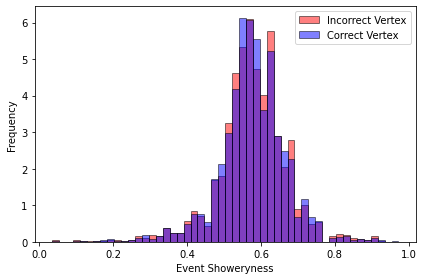

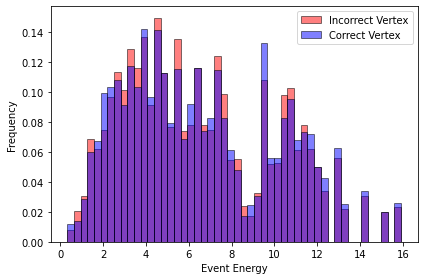

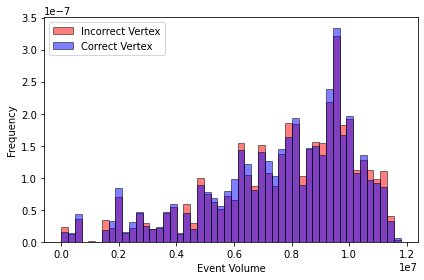

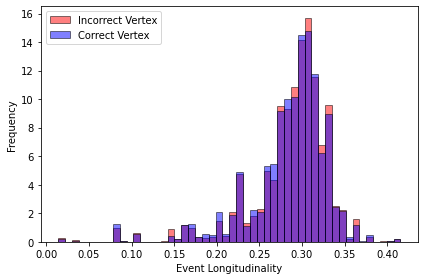

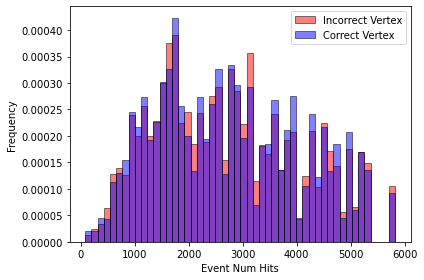

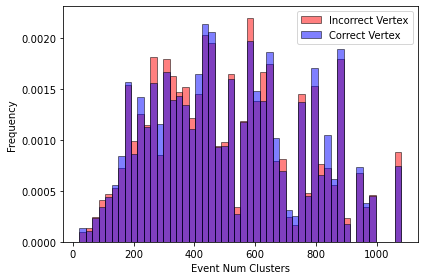

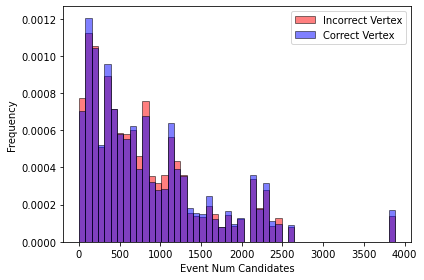

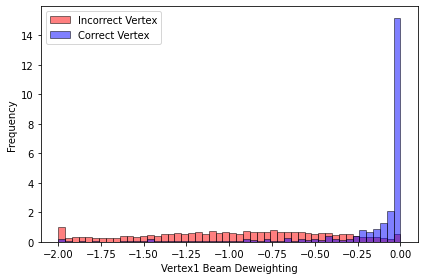

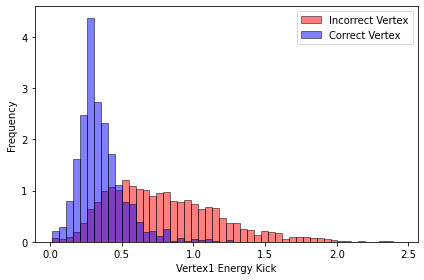

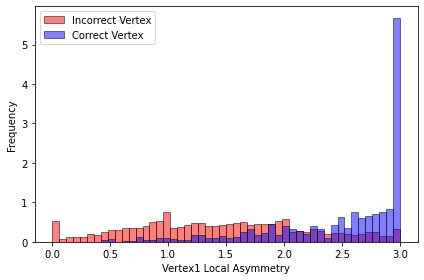

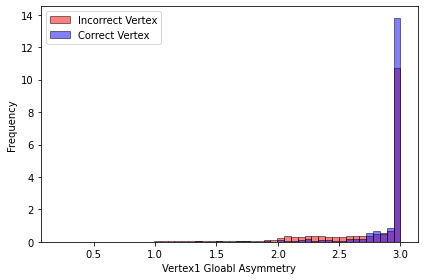

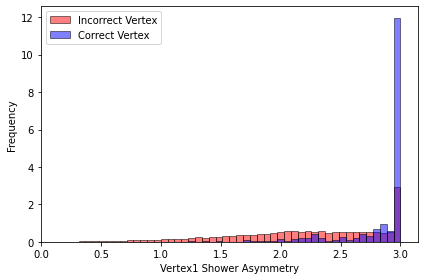

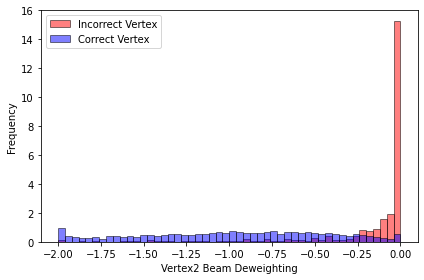

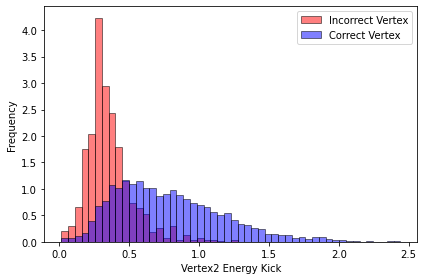

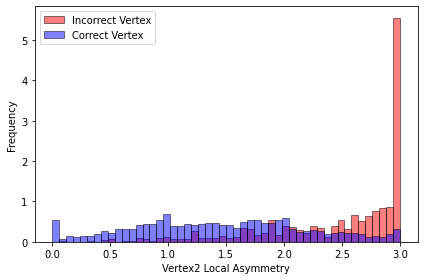

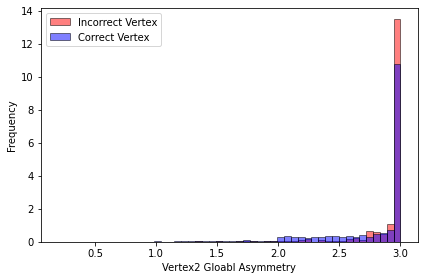

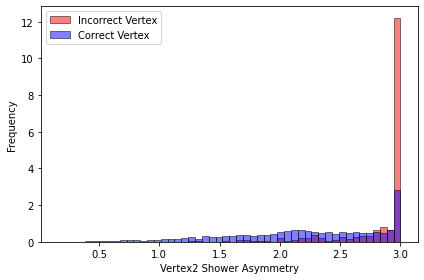

In [26]:
# Make plots drawing the variables for signal/background
DrawVariablesDF(df, params)

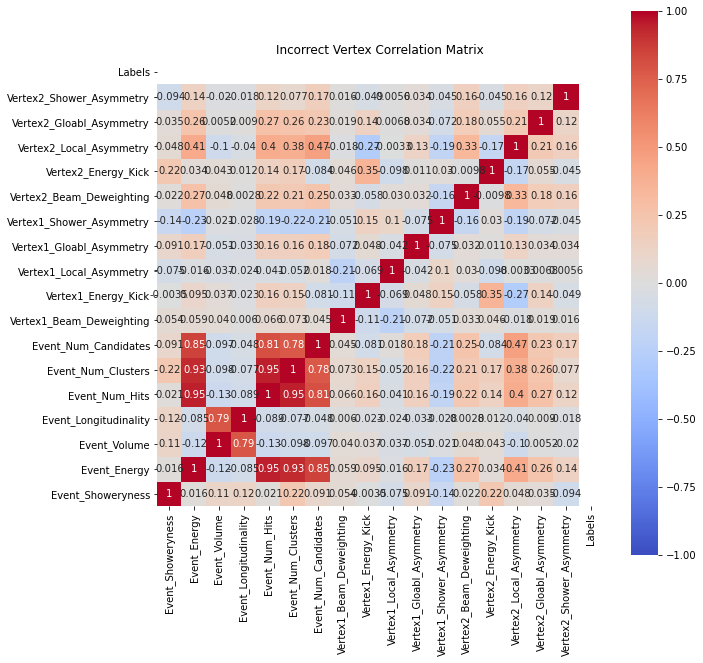

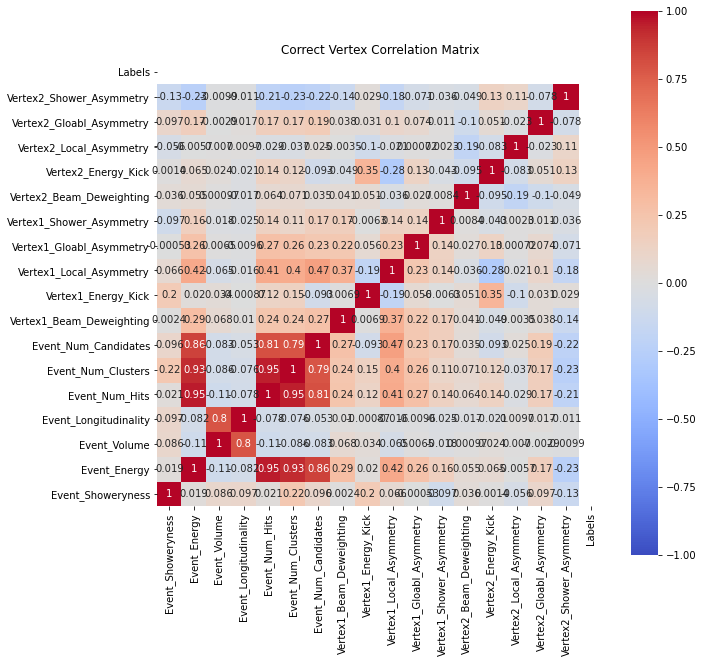

In [27]:
# Make correlation matricies
Correlation(df[df['Labels']==params['signalDefs'][0]], params['labelNames'][0] + ' Correlation Matrix')
Correlation(df[df['Labels']==params['signalDefs'][1]], params['labelNames'][1] + ' Correlation Matrix')

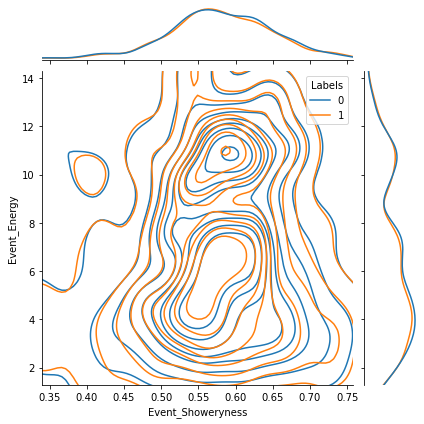

In [29]:
# If we want to make a plot comparing two variables;
#xMetric = 'Event_Showeryness'
#yMetric = 'Event_Energy'
#sns.jointplot(data=df, x=xMetric, y=yMetric, hue='Labels', kind='kde',
#              xlim=(np.quantile(df[xMetric], 0.02), np.quantile(df[xMetric], 0.98)), 
#              ylim=(np.quantile(df[yMetric], 0.02), np.quantile(df[yMetric], 0.98)))

In [ ]:
# For plotting all combos, not very useful as we have too many variables
# sns.pairplot(df, hue='Labels')

In [30]:
# Define size of grid search
depthRange = 4
treeRange = 4

# Set up ranges for grid search
depthArray = np.linspace(1, depthRange, depthRange, dtype=int)
treeArray = np.logspace(0, treeRange-1, treeRange, dtype=int)
#treeArray = np.linspace(100, 100*treeRange, treeRange, dtype=int)

# Print arrays for debugging
print ("Depth Array:", depthArray)
print ("Tree Array: ", treeArray)

# Construct a dictionary to loop over
paramGrid = dict(base_estimator__max_depth=depthArray, n_estimators=treeArray)

# Perform the grid search
grid = GridSearchCV(baseBDT, param_grid=paramGrid, cv=cv, n_jobs=nCores, 
                    verbose=9, refit=True, return_train_score=True)


Depth Array: [1 2 3 4]
Tree Array:  [   1   10  100 1000]


In [31]:
# Run the grid search
grid.fit(xTrain, yTrain)

print("The best parameters are %s with a score of %0.2f"% 
      (grid.best_params_, grid.best_score_))

# Put the output of the grid in a conveneant df
gridResults = pd.DataFrame(grid.cv_results_)
gridResults.rename(columns={"param_base_estimator__max_depth": "MaxDepth"}, inplace=True)
gridResults.rename(columns={"param_n_estimators": "NTrees"}, inplace=True)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.5min finished


The best parameters are {'base_estimator__max_depth': 4, 'n_estimators': 1000} with a score of 0.99


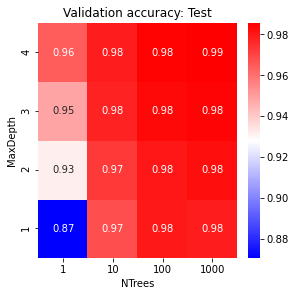

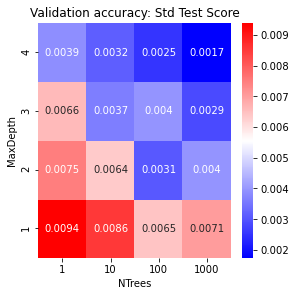

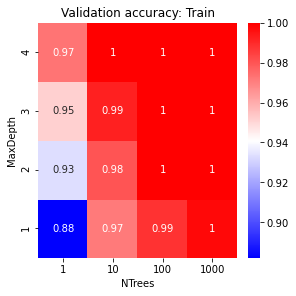

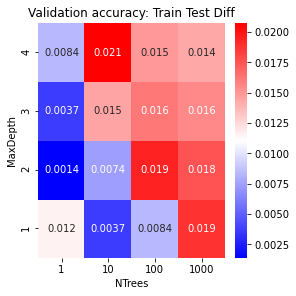

NTrees      1        10      100     1000
MaxDepth                                 
1         0.8590  0.96430  0.9714  0.9604
2         0.9306  0.96560  0.9612  0.9648
3         0.9447  0.96325  0.9676  0.9688
4         0.9564  0.95825  0.9700  0.9712
0.9713999999999998


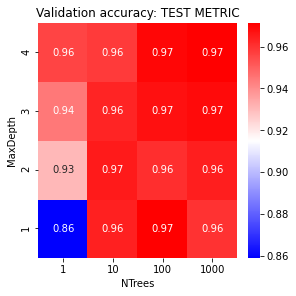

In [32]:
testScores = gridResults.pivot("MaxDepth", "NTrees", "mean_test_score")
testStd = gridResults.pivot("MaxDepth", "NTrees", "std_test_score")
trainScores = gridResults.pivot("MaxDepth", "NTrees", "mean_train_score")

trainTestDiff = trainScores - testScores

plt.figure(figsize=(4, 4), constrained_layout=True)
sns.heatmap(testScores, cmap='bwr', linewidths=0, annot=True)
plt.title('Validation accuracy: Test')
plt.gca().invert_yaxis()
plt.savefig('TestScores.png')
plt.show()

plt.figure(figsize=(4, 4), constrained_layout=True)
sns.heatmap(testStd, cmap='bwr', linewidths=0, annot=True)
plt.title('Validation accuracy: Std Test Score')
plt.gca().invert_yaxis()
plt.savefig('TrainStds.png')
plt.show()

plt.figure(figsize=(4, 4), constrained_layout=True)
sns.heatmap(trainScores, cmap='bwr', linewidths=0, annot=True)
plt.title('Validation accuracy: Train')
plt.gca().invert_yaxis()
plt.savefig('TrainScores.png')
plt.show()

plt.figure(figsize=(4, 4), constrained_layout=True)
sns.heatmap(trainTestDiff, cmap='bwr', linewidths=0, annot=True)
plt.title('Validation accuracy: Train Test Diff')
plt.gca().invert_yaxis()
plt.savefig('TrainTestDiff.png')
plt.show()

# This is my attempt at trying to finds a metric that maximises performance whilst
# minimising overtraining without haveing to do a KS test
myTestMetric = testScores - abs(trainTestDiff)

print (myTestMetric)
print (myTestMetric.max().max())

plt.figure(figsize=(4, 4), constrained_layout=True)
sns.heatmap(myTestMetric, cmap='bwr', linewidths=0, annot=True)
plt.title('Validation accuracy: TEST METRIC')
plt.gca().invert_yaxis()
plt.savefig('test.png')
plt.show()

In [33]:
# Reference BDT with controlled hyperparams
baseBDT.fit(xTrain,yTrain)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=3),
                   n_estimators=100, random_state=42)

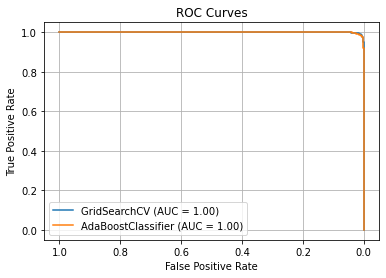

In [34]:
# Plot ROC curves
fig, ax = plt.subplots()
metrics.plot_roc_curve(grid, xTest, yTest, ax=ax)
metrics.plot_roc_curve(baseBDT, xTest, yTest, ax=ax)

plt.title("ROC Curves")
ax.invert_xaxis()
ax.legend()
ax.grid()

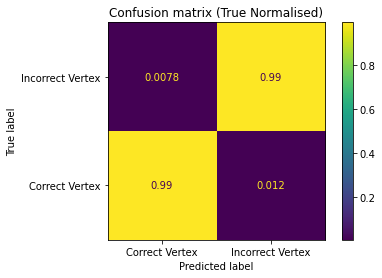

In [35]:
# Plot Confusion Matricies
fig, ax = plt.subplots()
metrics.plot_confusion_matrix(grid, xTest, yTest, display_labels=params['labelNames'],
                             ax=ax, normalize='true')
ax.invert_xaxis()
#ax.invert_zaxis()
plt.title("Confusion matrix (True Normalised)")
plt.show()

In [36]:
# Print more detailed performance info
bdtPredicted = baseBDT.predict(xTest)
gridPredicted = grid.predict(xTest)

print ("Background (0): ", params['labelNames'][0])
print ("Signal (1): ", params['labelNames'][1])
print ("BDT:\n", metrics.classification_report(yTest, bdtPredicted))
print ("Grid:\n", metrics.classification_report(yTest, gridPredicted))

Background (0):  Incorrect Vertex
Signal (1):  Correct Vertex
BDT:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2569
           1       0.99      0.99      0.99      2431

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000

Grid:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2569
           1       0.99      0.99      0.99      2431

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



In [42]:
# Search performance over training sample size
train_sizes_array = np.linspace(0.0,1, 20)

train_sizes, train_scores, test_scores = learning_curve, baseBDT, features, 
    labels, train_sizes=train_sizes_array[1:], n_jobs=nCores, verbose=9, cv=cv

mean_train_scores = np.mean(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)

std_train_scores = np.std(train_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)

IndentationError: unexpected indent (<ipython-input-42-d8fbddd1d4e2>, line 5)

In [ ]:
# Plot training progression
fig, ax = plt.subplots()
plt.title("Training Progression")
plt.xlabel("Number of Training Examples")
plt.ylabel("Score")

plt.plot(train_sizes, mean_train_scores, label='Train Score', color='b')
plt.fill_between(train_sizes, mean_train_scores - std_train_scores,
                         mean_train_scores + std_train_scores, alpha=0.1,
                         color="b")

plt.plot(train_sizes, mean_test_scores, label='Test Score', color='r')
plt.fill_between(train_sizes, mean_test_scores - std_test_scores,
                         mean_test_scores + std_test_scores, alpha=0.1,
                         color="r")
#plt.plot(train_sizes, std_test_scores, label='Test Score Std.', color='k')

plt.grid()
plt.legend()

In [ ]:
# Search over a metric
cppalplhaArray = np.linspace(0,0.001,11)

train_scores, test_scores = validation_curve(
    baseBDT, features, labels, param_name='base_estimator__ccp_alpha',
    param_range=cppalplhaArray, n_jobs=nCores, verbose=9, cv=cv)

mean_train_scores = np.mean(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)

std_train_scores = np.std(train_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)

print ("Means: "+str(mean_test_scores)+" and std. "
       +str(std_test_scores))

In [ ]:
# Plot grid search
plt.plot(cppalplhaArray, mean_train_scores, label='Train Score', color='b')
plt.fill_between(cppalplhaArray, mean_train_scores - std_train_scores,
                         mean_train_scores + std_train_scores, alpha=0.1,
                         color="b")
plt.plot(cppalplhaArray, mean_test_scores, label='Test Score', color='r')
plt.fill_between(cppalplhaArray, mean_test_scores - std_test_scores,
                         mean_test_scores + std_test_scores, alpha=0.1,
                         color="r")
plt.grid()
#plt.xscale('log')
plt.legend()

In [ ]:
# Search over a metric
learningRateArray = np.linspace(0.1,1.5,15)

train_scores, test_scores = validation_curve(
    baseBDT, features, labels, param_name='learning_rate',
    param_range=learningRateArray, n_jobs=nCores, verbose=9, cv=cv)

mean_train_scores = np.mean(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)

std_train_scores = np.std(train_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)

print ("Means: "+str(mean_test_scores)+" and std. "
       +str(std_test_scores))

In [ ]:
# Plot grid search
plt.plot(learningRateArray, mean_train_scores, label='Train Score', color='b')
plt.fill_between(learningRateArray, mean_train_scores - std_train_scores,
                         mean_train_scores + std_train_scores, alpha=0.1,
                         color="b")
plt.plot(learningRateArray, mean_test_scores, label='Test Score', color='r')
plt.fill_between(learningRateArray, mean_test_scores - std_test_scores,
                         mean_test_scores + std_test_scores, alpha=0.1,
                         color="r")
plt.grid()
#plt.xscale('log')
plt.legend()

In [ ]:
# Plot importance of features
importanceDF = pd.DataFrame({'Features': featureNames, 'Importance Score':baseBDT.feature_importances_})
print (importanceDF.sort_values(by=['Importance Score']))
ax = importanceDF.sort_values(by=['Importance Score'])\
    .plot(kind='barh', x='Features', y='Importance Score')

In [ ]:
# Print all tunable params
baseBDT.get_params().keys()

In [ ]:
import PandoraBDT
reload (PandoraBDT)
from PandoraBDT import *

parameters = {
  'ClassNames': ['True Vertex', 'Incorrect Vertex'],
  'SignalDefinition': [1, 0],
  'PlotColors': ['b', 'r'],
  'nBins': 100,
  'PlotStep': 1.0,
  'OptimalBinCut': 0,
  'OptimalScoreCut': 0.0,
  'nTrees': 100,
  'TreeDepth': 3
}


FindOptimalSignificanceCut(baseBDT, xTest, yTest, parameters)
PlotBdtScores(baseBDT, xTest, yTest, xTrain, yTrain, 'Vertex Region', parameters)

In [ ]:
WriteXmlFile(BDTName+".xml", baseBDT, BDTName)
SerializeToPkl(BDTName+".pkl", baseBDT)